# Train ORCNN on amodal datasets

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog,MetadataCatalog
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10,10
def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.show()
    
# run on gpu 0 (NVIDIA Geforce GTX 1080Ti) and gpu 1 (NVIDIA Geforce GTX 1070Ti)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Register the amodal datasets 

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("broccoli_amodal_train", {}, "datasets/broccoli_amodal/train/annotations.json", "datasets/broccoli_amodal/train")
register_coco_instances("broccoli_amodal_val", {}, "datasets/broccoli_amodal/val/annotations.json", "datasets/broccoli_amodal/val")
register_coco_instances("broccoli_amodal_test", {}, "datasets/broccoli_amodal/test/annotations.json", "datasets/broccoli_amodal/test")

In [3]:
broccoli_amodal_train_metadata = MetadataCatalog.get("broccoli_amodal_train")
print(broccoli_amodal_train_metadata)

broccoli_amodal_val_metadata = MetadataCatalog.get("broccoli_amodal_val")
print(broccoli_amodal_val_metadata)

broccoli_amodal_test_metadata = MetadataCatalog.get("broccoli_amodal_test")
print(broccoli_amodal_test_metadata)

Metadata(evaluator_type='coco', image_root='datasets/broccoli_amodal/train', json_file='datasets/broccoli_amodal/train/annotations.json', name='broccoli_amodal_train')
Metadata(evaluator_type='coco', image_root='datasets/broccoli_amodal/val', json_file='datasets/broccoli_amodal/val/annotations.json', name='broccoli_amodal_val')
Metadata(evaluator_type='coco', image_root='datasets/broccoli_amodal/test', json_file='datasets/broccoli_amodal/test/annotations.json', name='broccoli_amodal_test')


In [4]:
dataset_dicts_train = DatasetCatalog.get("broccoli_amodal_train")
dataset_dicts_val = DatasetCatalog.get("broccoli_amodal_val")
dataset_dicts_test = DatasetCatalog.get("broccoli_amodal_test")

[06/23 10:35:45 d2.data.datasets.coco]: Loaded 894 images in COCO format from datasets/broccoli_amodal/train/annotations.json
[06/23 10:35:46 d2.data.datasets.coco]: Loaded 300 images in COCO format from datasets/broccoli_amodal/val/annotations.json
[06/23 10:35:46 d2.data.datasets.coco]: Loaded 300 images in COCO format from datasets/broccoli_amodal/test/annotations.json


## Visualize the amodal dataset 

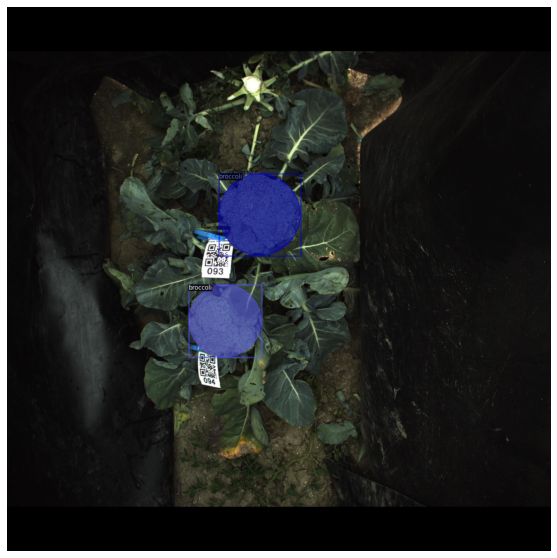

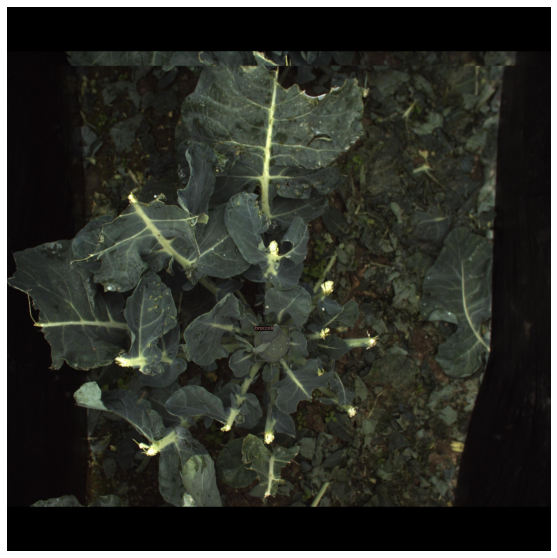

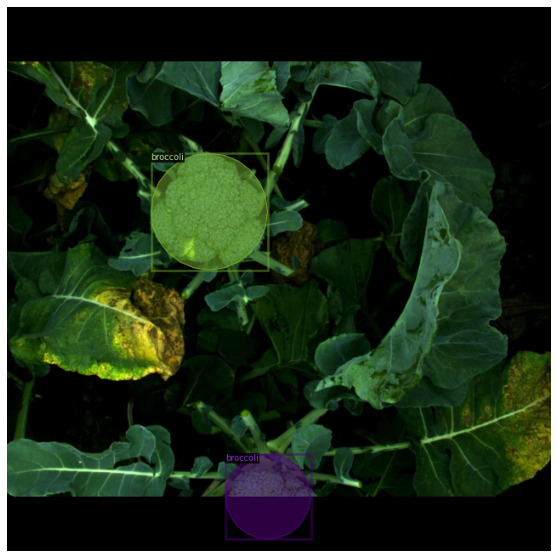

In [5]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='segmentation')
    imshow(vis.get_image()[:, :, ::-1])

## Visualize the visible masks (modal dataset) 

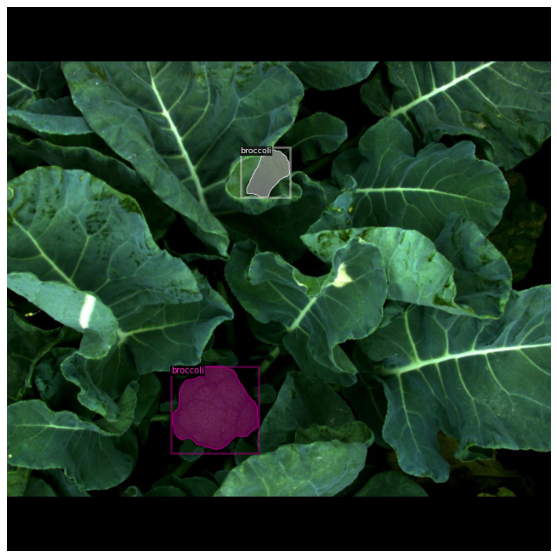

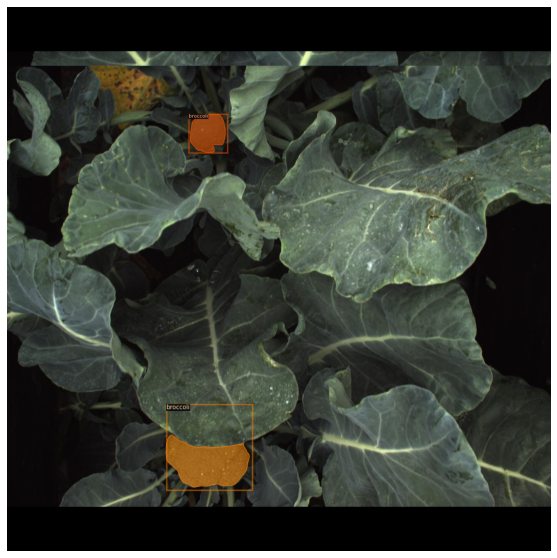

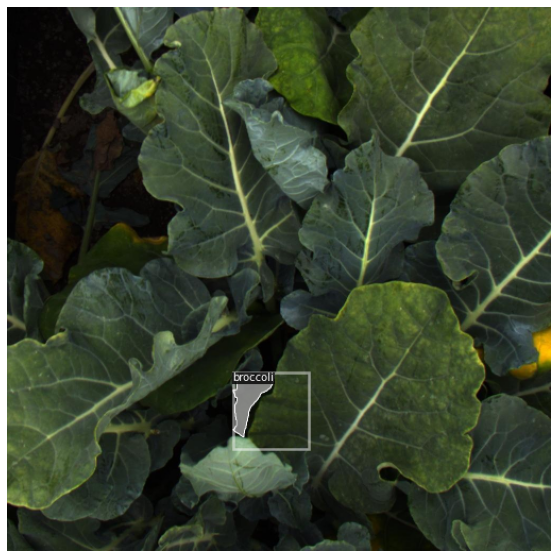

In [6]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d, segm='visible_mask')
    imshow(vis.get_image()[:, :, ::-1])

## Initialize the training and inference parameters

In [7]:
import os
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_orcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("broccoli_amodal_train",)
cfg.DATASETS.VAL = ("broccoli_amodal_val",)
cfg.DATASETS.TEST = ("broccoli_amodal_test",)

cfg.NUM_GPUS = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
 # Let training initialize from model zoo

# solver file settings extracted from: https://github.com/facebookresearch/Detectron/blob/master/configs/04_2018_gn_baselines/scratch_e2e_mask_rcnn_R-101-FPN_3x_gn.yaml
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (0, 4000, 4500)
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
#cfg.SOLVER.MAX_ITER = 270000
#cfg.SOLVER.STEPS = (0, 210000, 250000)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (broccoli)

# https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.OUTPUT_DIR = "weights/broccoli_amodal_visible"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 

[06/23 10:36:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/23 10:36:15 d2.data.datasets.coco]: Loaded 894 images in COCO format from datasets/broccoli_amodal/train/annotations.json
[06/23 10:36:15 d2.data.build]: Removed 0 images with no usable annotations. 894 images left.
[06/23 10:36:15 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  broccoli  | 1415         |
|            |              |
[06/23 10:36:15 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[06/23 10:36:15 d2.data.build]: Using training sampler TrainingSampler


## Start the training 

In [8]:
trainer.resume_or_load(resume=False)
trainer.train()

[06/23 10:36:21 d2.engine.train_loop]: Starting training from iteration 0
[06/23 10:36:34 d2.utils.events]: eta: 0:50:12  iter: 19  total_loss: 2.436  loss_cls: 0.683  loss_box_reg: 0.271  loss_amodal_mask: 0.694  loss_visible_mask: 0.691  loss_rpn_cls: 0.065  loss_rpn_loc: 0.007  time: 0.6116  data_time: 0.0142  lr: 0.000040  max_mem: 4307M
[06/23 10:36:47 d2.utils.events]: eta: 0:53:29  iter: 39  total_loss: 2.043  loss_cls: 0.272  loss_box_reg: 0.307  loss_amodal_mask: 0.672  loss_visible_mask: 0.684  loss_rpn_cls: 0.012  loss_rpn_loc: 0.005  time: 0.6378  data_time: 0.0025  lr: 0.000080  max_mem: 4380M
[06/23 10:37:00 d2.utils.events]: eta: 0:54:22  iter: 59  total_loss: 1.866  loss_cls: 0.196  loss_box_reg: 0.333  loss_amodal_mask: 0.614  loss_visible_mask: 0.667  loss_rpn_cls: 0.015  loss_rpn_loc: 0.005  time: 0.6489  data_time: 0.0026  lr: 0.000120  max_mem: 4547M
[06/23 10:37:13 d2.utils.events]: eta: 0:53:21  iter: 79  total_loss: 1.818  loss_cls: 0.171  loss_box_reg: 0.375  l

[06/23 10:42:44 d2.utils.events]: eta: 0:46:42  iter: 599  total_loss: 0.634  loss_cls: 0.037  loss_box_reg: 0.135  loss_amodal_mask: 0.212  loss_visible_mask: 0.164  loss_rpn_cls: 0.002  loss_rpn_loc: 0.005  time: 0.6364  data_time: 0.0024  lr: 0.001199  max_mem: 4737M
[06/23 10:42:56 d2.utils.events]: eta: 0:46:32  iter: 619  total_loss: 0.450  loss_cls: 0.024  loss_box_reg: 0.092  loss_amodal_mask: 0.181  loss_visible_mask: 0.139  loss_rpn_cls: 0.002  loss_rpn_loc: 0.004  time: 0.6367  data_time: 0.0024  lr: 0.001239  max_mem: 4737M
[06/23 10:43:09 d2.utils.events]: eta: 0:46:17  iter: 639  total_loss: 0.432  loss_cls: 0.015  loss_box_reg: 0.082  loss_amodal_mask: 0.171  loss_visible_mask: 0.124  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.6362  data_time: 0.0027  lr: 0.001279  max_mem: 4737M
[06/23 10:43:22 d2.utils.events]: eta: 0:46:04  iter: 659  total_loss: 0.483  loss_cls: 0.020  loss_box_reg: 0.094  loss_amodal_mask: 0.207  loss_visible_mask: 0.130  loss_rpn_cls: 0.001 

[06/23 10:49:09 d2.utils.events]: eta: 0:40:23  iter: 1199  total_loss: 0.571  loss_cls: 0.077  loss_box_reg: 0.177  loss_amodal_mask: 0.167  loss_visible_mask: 0.117  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.6381  data_time: 0.0024  lr: 0.002000  max_mem: 4825M
[06/23 10:49:22 d2.utils.events]: eta: 0:40:12  iter: 1219  total_loss: 0.469  loss_cls: 0.049  loss_box_reg: 0.149  loss_amodal_mask: 0.167  loss_visible_mask: 0.089  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.6385  data_time: 0.0024  lr: 0.002000  max_mem: 4825M
[06/23 10:49:35 d2.utils.events]: eta: 0:40:00  iter: 1239  total_loss: 0.470  loss_cls: 0.041  loss_box_reg: 0.124  loss_amodal_mask: 0.170  loss_visible_mask: 0.129  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  time: 0.6385  data_time: 0.0023  lr: 0.002000  max_mem: 4825M
[06/23 10:49:48 d2.utils.events]: eta: 0:39:52  iter: 1259  total_loss: 0.477  loss_cls: 0.035  loss_box_reg: 0.151  loss_amodal_mask: 0.162  loss_visible_mask: 0.100  loss_rpn_cls: 0.

[06/23 10:55:40 d2.utils.events]: eta: 0:34:34  iter: 1799  total_loss: 0.411  loss_cls: 0.045  loss_box_reg: 0.139  loss_amodal_mask: 0.138  loss_visible_mask: 0.099  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.6429  data_time: 0.0024  lr: 0.002000  max_mem: 4868M
[06/23 10:55:53 d2.utils.events]: eta: 0:34:21  iter: 1819  total_loss: 0.367  loss_cls: 0.032  loss_box_reg: 0.122  loss_amodal_mask: 0.136  loss_visible_mask: 0.085  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6427  data_time: 0.0022  lr: 0.002000  max_mem: 4868M
[06/23 10:56:06 d2.utils.events]: eta: 0:34:09  iter: 1839  total_loss: 0.412  loss_cls: 0.034  loss_box_reg: 0.096  loss_amodal_mask: 0.135  loss_visible_mask: 0.114  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  time: 0.6429  data_time: 0.0024  lr: 0.002000  max_mem: 4868M
[06/23 10:56:19 d2.utils.events]: eta: 0:34:00  iter: 1859  total_loss: 0.418  loss_cls: 0.040  loss_box_reg: 0.146  loss_amodal_mask: 0.149  loss_visible_mask: 0.084  loss_rpn_cls: 0.

[06/23 11:02:13 d2.utils.events]: eta: 0:28:19  iter: 2399  total_loss: 0.435  loss_cls: 0.037  loss_box_reg: 0.124  loss_amodal_mask: 0.124  loss_visible_mask: 0.103  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.6455  data_time: 0.0025  lr: 0.002000  max_mem: 4868M
[06/23 11:02:27 d2.utils.events]: eta: 0:28:07  iter: 2419  total_loss: 0.344  loss_cls: 0.032  loss_box_reg: 0.122  loss_amodal_mask: 0.119  loss_visible_mask: 0.069  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6456  data_time: 0.0024  lr: 0.002000  max_mem: 4868M
[06/23 11:02:40 d2.utils.events]: eta: 0:27:52  iter: 2439  total_loss: 0.360  loss_cls: 0.031  loss_box_reg: 0.096  loss_amodal_mask: 0.100  loss_visible_mask: 0.090  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6458  data_time: 0.0025  lr: 0.002000  max_mem: 4868M
[06/23 11:02:53 d2.utils.events]: eta: 0:27:40  iter: 2459  total_loss: 0.397  loss_cls: 0.033  loss_box_reg: 0.125  loss_amodal_mask: 0.124  loss_visible_mask: 0.091  loss_rpn_cls: 0.

[06/23 11:08:48 d2.utils.events]: eta: 0:21:51  iter: 2999  total_loss: 0.410  loss_cls: 0.043  loss_box_reg: 0.125  loss_amodal_mask: 0.132  loss_visible_mask: 0.085  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.6475  data_time: 0.0023  lr: 0.002000  max_mem: 4868M
[06/23 11:09:00 d2.utils.events]: eta: 0:21:37  iter: 3019  total_loss: 0.327  loss_cls: 0.035  loss_box_reg: 0.095  loss_amodal_mask: 0.113  loss_visible_mask: 0.086  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6474  data_time: 0.0022  lr: 0.002000  max_mem: 4868M
[06/23 11:09:13 d2.utils.events]: eta: 0:21:25  iter: 3039  total_loss: 0.275  loss_cls: 0.025  loss_box_reg: 0.089  loss_amodal_mask: 0.095  loss_visible_mask: 0.070  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6474  data_time: 0.0024  lr: 0.002000  max_mem: 4868M
[06/23 11:09:26 d2.utils.events]: eta: 0:21:11  iter: 3059  total_loss: 0.300  loss_cls: 0.030  loss_box_reg: 0.097  loss_amodal_mask: 0.101  loss_visible_mask: 0.082  loss_rpn_cls: 0.

[06/23 11:15:22 d2.utils.events]: eta: 0:15:21  iter: 3599  total_loss: 0.452  loss_cls: 0.035  loss_box_reg: 0.145  loss_amodal_mask: 0.128  loss_visible_mask: 0.096  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  time: 0.6489  data_time: 0.0025  lr: 0.002000  max_mem: 4868M
[06/23 11:15:35 d2.utils.events]: eta: 0:15:08  iter: 3619  total_loss: 0.358  loss_cls: 0.027  loss_box_reg: 0.109  loss_amodal_mask: 0.120  loss_visible_mask: 0.080  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6490  data_time: 0.0025  lr: 0.002000  max_mem: 4868M
[06/23 11:15:48 d2.utils.events]: eta: 0:14:54  iter: 3639  total_loss: 0.325  loss_cls: 0.022  loss_box_reg: 0.116  loss_amodal_mask: 0.101  loss_visible_mask: 0.080  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6489  data_time: 0.0025  lr: 0.002000  max_mem: 4868M
[06/23 11:16:01 d2.utils.events]: eta: 0:14:40  iter: 3659  total_loss: 0.309  loss_cls: 0.021  loss_box_reg: 0.094  loss_amodal_mask: 0.097  loss_visible_mask: 0.080  loss_rpn_cls: 0.

[06/23 11:21:55 d2.utils.events]: eta: 0:08:45  iter: 4199  total_loss: 0.274  loss_cls: 0.024  loss_box_reg: 0.086  loss_amodal_mask: 0.091  loss_visible_mask: 0.072  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6497  data_time: 0.0025  lr: 0.000200  max_mem: 4868M
[06/23 11:22:08 d2.utils.events]: eta: 0:08:32  iter: 4219  total_loss: 0.269  loss_cls: 0.024  loss_box_reg: 0.074  loss_amodal_mask: 0.101  loss_visible_mask: 0.070  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6496  data_time: 0.0023  lr: 0.000200  max_mem: 4868M
[06/23 11:22:21 d2.utils.events]: eta: 0:08:18  iter: 4239  total_loss: 0.264  loss_cls: 0.018  loss_box_reg: 0.076  loss_amodal_mask: 0.082  loss_visible_mask: 0.069  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6496  data_time: 0.0027  lr: 0.000200  max_mem: 4868M
[06/23 11:22:34 d2.utils.events]: eta: 0:08:05  iter: 4259  total_loss: 0.285  loss_cls: 0.023  loss_box_reg: 0.080  loss_amodal_mask: 0.090  loss_visible_mask: 0.075  loss_rpn_cls: 0.

[06/23 11:28:29 d2.utils.events]: eta: 0:02:11  iter: 4799  total_loss: 0.212  loss_cls: 0.016  loss_box_reg: 0.068  loss_amodal_mask: 0.069  loss_visible_mask: 0.064  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6504  data_time: 0.0023  lr: 0.000020  max_mem: 4868M
[06/23 11:28:42 d2.utils.events]: eta: 0:01:58  iter: 4819  total_loss: 0.354  loss_cls: 0.022  loss_box_reg: 0.087  loss_amodal_mask: 0.099  loss_visible_mask: 0.097  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6503  data_time: 0.0023  lr: 0.000020  max_mem: 4868M
[06/23 11:28:55 d2.utils.events]: eta: 0:01:45  iter: 4839  total_loss: 0.268  loss_cls: 0.022  loss_box_reg: 0.090  loss_amodal_mask: 0.083  loss_visible_mask: 0.061  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6503  data_time: 0.0025  lr: 0.000020  max_mem: 4868M
[06/23 11:29:08 d2.utils.events]: eta: 0:01:32  iter: 4859  total_loss: 0.273  loss_cls: 0.023  loss_box_reg: 0.088  loss_amodal_mask: 0.080  loss_visible_mask: 0.077  loss_rpn_cls: 0.

## Visualize the training process in tensorboard

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /home/pieterdeeplearn/harvestcnn/weights/broccoli_amodal_visible

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Evaluation

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

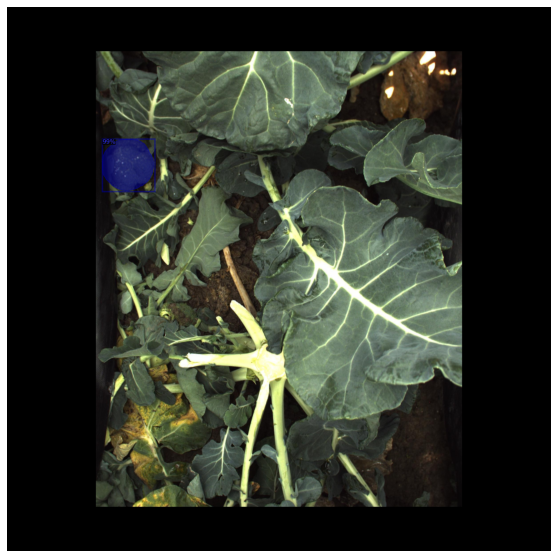

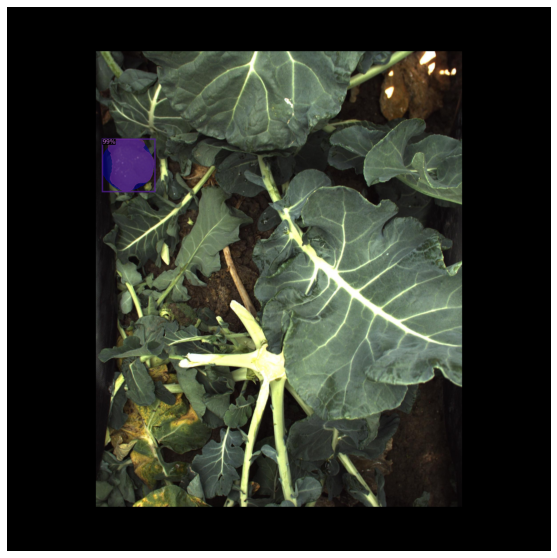

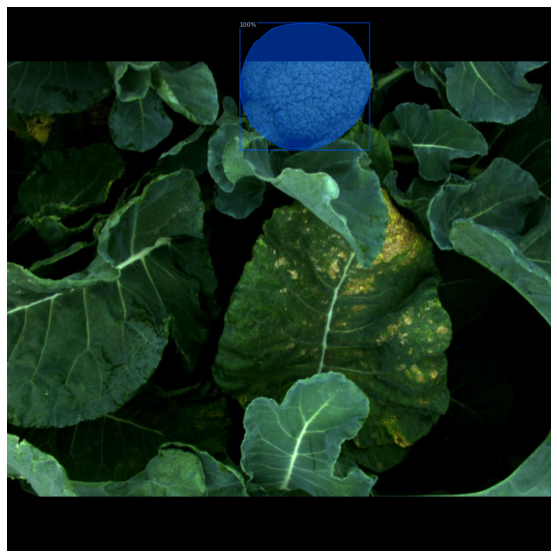

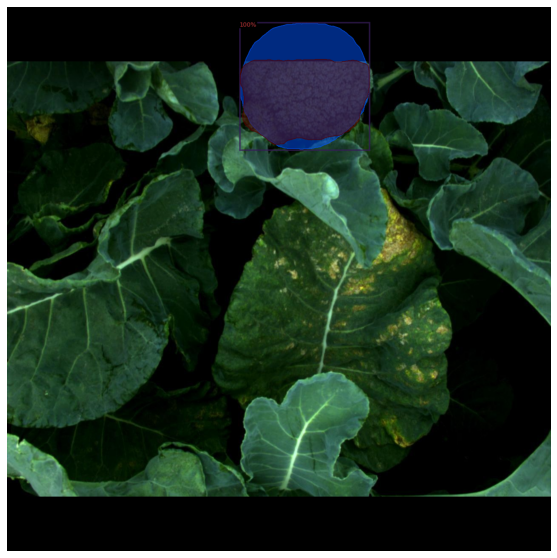

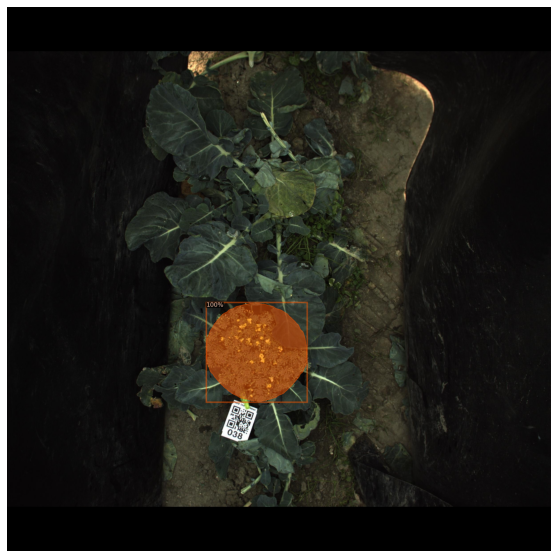

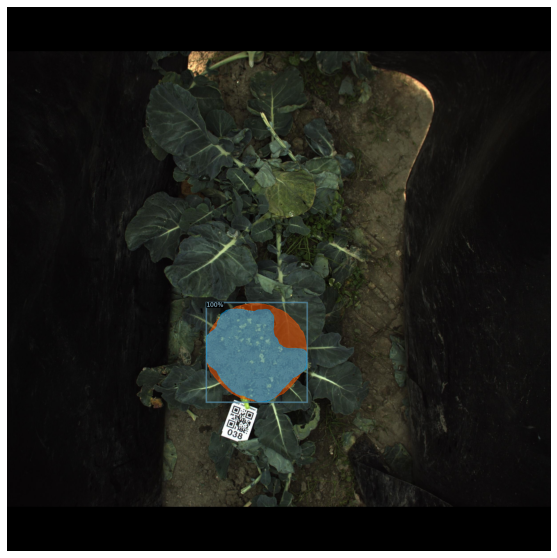

In [19]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    amodal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(amodal_mask.get_image()[:, :, ::-1])
    modal_mask = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(modal_mask.get_image()[:, :, ::-1])

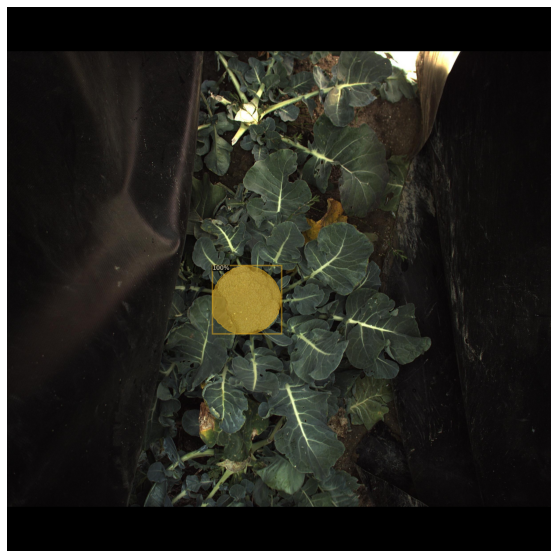

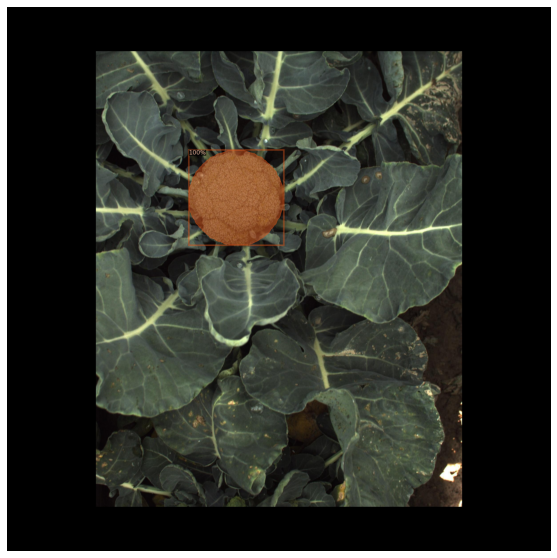

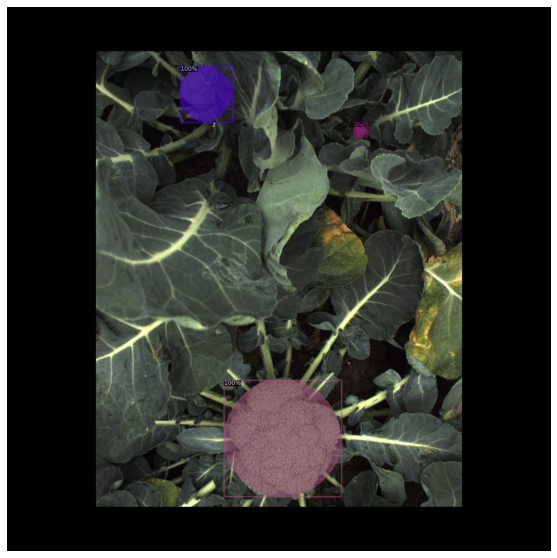

In [20]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    imshow(vis.get_image()[:, :, ::-1])

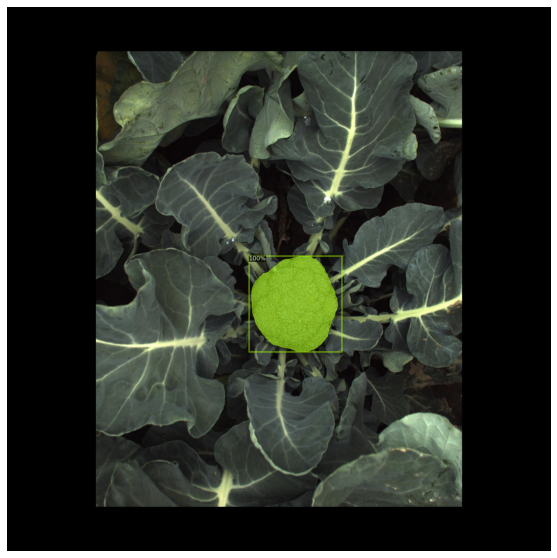

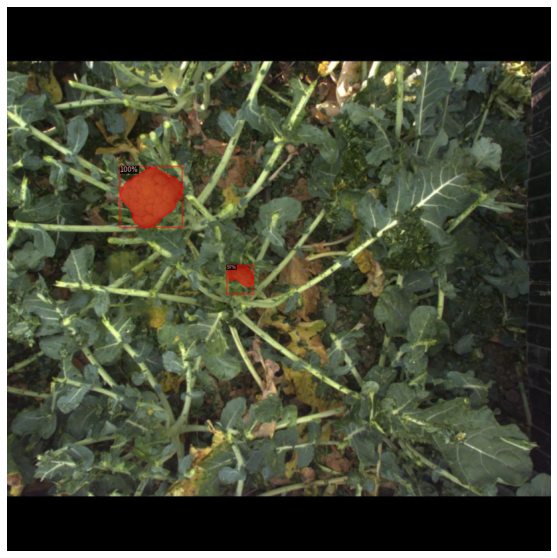

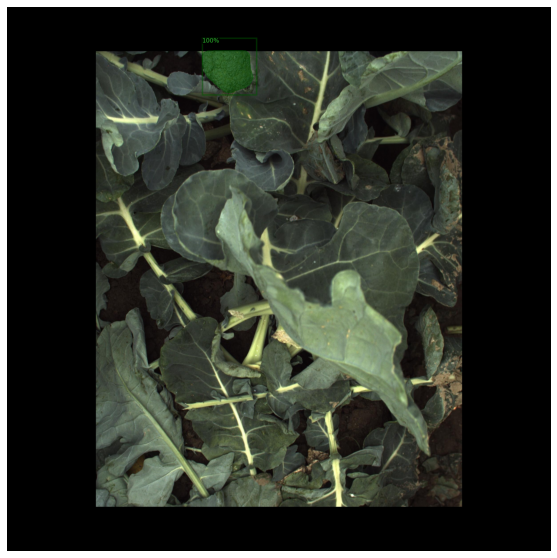

In [21]:
for d in random.sample(dataset_dicts_test, 3):       
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img[:, :, ::-1], metadata=broccoli_amodal_test_metadata, scale=0.8)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"), 'pred_visible_masks')
    imshow(vis.get_image()[:, :, ::-1])

In [18]:
#  evaluate its performance using AP metric implemented in COCO API.
from detectron2.evaluation import AmodalEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = AmodalEvaluator("broccoli_amodal_test", cfg, False, output_dir="/home/pieterdeeplearn/ORCNN/Results/broccoli_amodal_visible")
val_loader = build_detection_test_loader(cfg, "broccoli_amodal_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[06/23 11:34:51 d2.data.datasets.coco]: Loaded 300 images in COCO format from datasets/broccoli_amodal/test/annotations.json
[06/23 11:34:51 d2.evaluation.evaluator]: Start inference on 300 images
[06/23 11:34:53 d2.evaluation.evaluator]: Inference done 11/300. 0.1151 s / img. ETA=0:00:44
[06/23 11:34:58 d2.evaluation.evaluator]: Inference done 44/300. 0.1147 s / img. ETA=0:00:39
[06/23 11:35:03 d2.evaluation.evaluator]: Inference done 77/300. 0.1149 s / img. ETA=0:00:34
[06/23 11:35:08 d2.evaluation.evaluator]: Inference done 111/300. 0.1148 s / img. ETA=0:00:28
[06/23 11:35:13 d2.evaluation.evaluator]: Inference done 146/300. 0.1149 s / img. ETA=0:00:23
[06/23 11:35:18 d2.evaluation.evaluator]: Inference done 185/300. 0.1144 s / img. ETA=0:00:16
[06/23 11:35:23 d2.evaluation.evaluator]: Inference done 225/300. 0.1142 s / img. ETA=0:00:10
[06/23 11:35:29 d2.evaluation.evaluator]: Inference done 264/300. 0.1140 s / img. ETA=0:00:05
[06/23 11:35:34 d2.evaluation.evaluator]: Inference do

OrderedDict([('bbox',
              {'AP': 74.43608343769719,
               'AP50': 94.38200259718545,
               'AP75': 81.36197884787246,
               'APs': nan,
               'APm': 43.6393709922991,
               'APl': 77.17561394334898}),
             ('segm',
              {'AP': 75.16978613667028,
               'AP50': 93.45610170259282,
               'AP75': 82.66248185077096,
               'APs': nan,
               'APm': 39.82337181169495,
               'APl': 78.39278179542602}),
             ('visible',
              {'AP': 79.06005307857492,
               'AP50': 95.52451776945257,
               'AP75': 86.86208761825928,
               'APs': nan,
               'APm': 38.12623215691839,
               'APl': 82.92450343580259})])